In [1]:
import pandas as pd
data = pd.read_csv('179-hw5-riskdata.csv',index_col=False,dtype=int)
data.head()

,income,smoke,cholesterol,bmi,exercise,attack,bp,angina,stroke,diabetes
0,6,2,2,4,2,2,1,2,2,3
1,2,2,1,3,1,2,1,2,2,3
2,6,1,2,3,1,2,3,2,2,3
3,2,1,2,4,2,2,1,2,2,1
4,5,1,2,3,2,2,3,2,2,3


In [2]:
#split data
data_int = data-1
nTrain = int(.75*len(data_int))
train = data_int[:nTrain]
valid = data_int[nTrain:]

In [3]:
#check data columns
train.columns


Index(['income', 'smoke', 'cholesterol', 'bmi', 'exercise', 'attack', 'bp',
       'angina', 'stroke', 'diabetes'],
      dtype='object')

In [4]:
# Build bayes network model
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator

root_model = BayesianModel([("income","bmi"),("income","smoke"),("income","exercise"),("income","cholesterol"),("income","bp"),
                       ("exercise","bmi"),("exercise","bp"),("exercise","cholesterol"),
                       ("smoke","bp"),("smoke","cholesterol"),
                       ("bmi","diabetes"),("bmi","stroke"),("bmi","attack"),("bmi","angina"),
                       ("bp","stroke"),("bp","attack"),("bp","angina"),
                       ("cholesterol","stroke"),("cholesterol","attack"),("cholesterol","angina")])

e:\anaconda3\envs\py36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


show bayes network 

In [41]:
def showBN(model,name = "bayes"):
    from graphviz import Digraph
    node_attr = dict(
        style="filled",
        shape = 'box',
        align = "left",
        fontsize = '12',
        ranksep = '0.1',
        height ="0.2"
    )
    dot = Digraph(node_attr=node_attr,graph_attr=dict(size='12,12'))
    seen = dict()
    edges = model.edges()
    for a,b in edges:
        dot.edge(a,b)
    
    dot.view(name,cleanup=True)
    return  dot

showBN(root_model)

Error: Could not open "bayes.pdf" for writing : Permission denied


CalledProcessError: Command '['dot', '-Kdot', '-Tpdf', '-O', 'bayes']' returned non-zero exit status 1. [stderr: b'Error: Could not open "bayes.pdf" for writing : Permission denied\r\n']

Use maximum likelihood to estimate network parameters

In [46]:
# Use maximum likelihood to estimate network parameters
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(root_model,train)

In [47]:
# Fit the model using the maximum likelihood estimation evaluation algorithm
root_model.fit(train,estimator=MaximumLikelihoodEstimator)

Show the tables you learned for p(Income) and p(E x ercisejIncome)

In [48]:
print("The maximum likelihood estimation estimates the probability distribution of income as")
print(root_model.get_cpds("income"))


The maximum likelihood estimation estimates the probability distribution of income as
+-----------+-----------+
| income(0) | 0.0486259 |
+-----------+-----------+
| income(1) | 0.0589277 |
+-----------+-----------+
| income(2) | 0.0732406 |
+-----------+-----------+
| income(3) | 0.0926373 |
+-----------+-----------+
| income(4) | 0.115643  |
+-----------+-----------+
| income(5) | 0.150993  |
+-----------+-----------+
| income(6) | 0.164419  |
+-----------+-----------+
| income(7) | 0.295514  |
+-----------+-----------+


In [49]:
print("The maximum likelihood estimation estimates the conditional probability distribution of P(exercise|Income)：")
print(root_model.get_cpds("exercise"))



The maximum likelihood estimation estimates the conditional probability distribution of P(exercise|Income)：
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
| income      | income(0)          | income(1)          | income(2)          | income(3)          | income(4)          | income(5)          | income(6)          | income(7)           |
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
| exercise(0) | 0.6244626490388515 | 0.6094638913058028 | 0.6336564351103932 | 0.6637857629427792 | 0.7024317042392825 | 0.7490596593877338 | 0.7916906543849549 | 0.8516689577855779  |
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------

What is the total number of probabilities you need to estimate for this network? (Only count “free”
probabilities, i.e., do not count any probability parameters that are deterministically known given the
others due to the fact that the probabilities are normalized to sum to one.)

In [50]:
def statics_parameters(mle):
    """
    :param mle: 评估算法
    :return: 
    """
    import numpy as np
    all_estimate_parameters = 0
    all_parameters = 0
    for p in mle.get_parameters():
        size = p.values.shape
        all_estimate_parameters+=(size[0]-1)*np.prod(size[1:])
        all_parameters += np.prod(size)
    return all_estimate_parameters,all_parameters

In [51]:
#View the amount of parameters that need to be estimated for the network：
all_estimate_parameters,all_parameters = statics_parameters(mle)
print("the total number of probabilities you need to estimate for this network:",all_estimate_parameters)
print("the total number of probabilities in the full joint distribution",all_parameters)

the total number of probabilities you need to estimate for this network: 307.0
the total number of probabilities in the full joint distribution 504


 Compute the average log-likelihood on the training data


In [12]:
import math
flat=lambda L: sum(map(flat,L),[]) if isinstance(L,list) else [L]

def average_log_likelihood(mle):
    """
    :param mle: 评估算法
    :return: 
    """

    sum_avg = 0
    sum_num = 0
    for p in mle.get_parameters():
        value = p.values.tolist()
        for v in flat(value):
            # Since there are 0, so 0 is filtered
            if v !=0:
                sum_num+=1
                sum_avg = math.log(v)
    return sum_avg/sum_num


Compute the average log-likelihood on the training data

In [13]:
train_mle = MaximumLikelihoodEstimator(root_model,train)
train_ave = average_log_likelihood(train_mle)
print("the average log-likelihood on the training data",train_ave)

the average log-likelihood on the training data -2.9711207477466814e-05


Compute the average log-likelihood on the validation data

In [14]:
valid_mle = MaximumLikelihoodEstimator(root_model,valid)
valid_ave = average_log_likelihood(valid_mle)
print("the average log-likelihood on the valid data",valid_ave)


the average log-likelihood on the valid data -2.2258799454562764e-05


One way to fix such estimates is to use a prior (or equivalently, a regularization term) in the parameter
estimation. A Dirichlet prior Dir(α) is conjugate to the discrete distribution, and so can be interpreted as
adding “pseudocounts” αi to each outcome i. Change your probability estimates to include this prior, using
αi = 1. (Equivalently, in each estimated probability, imagine that you saw every possible outcome once,
plus the number you actually saw in the training data.) After re-estimating your probabilities, print out the
log-likelihood of your training data and validation data on the new model.


Bayes network based on Dirichlet prior distribution

In [15]:
from  pgmpy.estimators import BayesianEstimator

In [16]:
def average_dirichlet_log_likelihood(dir_mle,columns):
    sum_avg = 0
    sum_num = 0
    for column in columns:
        cpd = dir_mle.estimate_cpd(column,prior_type='dirichlet',pseudo_counts=1.)
        value = cpd.values.tolist()
        for v in flat(value):
            sum_num+=1
            sum_avg = math.log(v)
    return sum_avg/sum_num

Log-likelihood of bayes network on training set based on Dirichlet prior distribution


In [17]:
dir_mle = BayesianEstimator(root_model,train)
train_ave = average_dirichlet_log_likelihood(dir_mle,train.columns)
print("the average log-likelihood on the training data",train_ave)

the average log-likelihood on the training data -0.007292841896101157


In [18]:
dir_mle = BayesianEstimator(root_model,valid)
valid_ave = average_dirichlet_log_likelihood(dir_mle,valid.columns)
print("the average log-likelihood on the valid data",valid_ave)

the average log-likelihood on the valid data -0.007377251611632393


Estimate the single-variable and pairwise marginal probability distributions ˆp(Xi), ˆp(Xi, X j) for each pair of
variables in the model. (Again, regularize your probability estimates by adding α = 1 to each outcome.)
Then, for each pair of variables, compute the empirical mutual information:

the empirical mutual information

In [19]:
import numpy as np
from sklearn.metrics import mutual_info_score,adjusted_mutual_info_score
from itertools import combinations
from joblib import Parallel, delayed

pbar = combinations(data.columns, 2)
vals = Parallel(n_jobs=5, prefer="threads")(
    delayed(mutual_info_score)(data.loc[:, u], data.loc[:, v]) for u, v in pbar
)
n_vars = len(data.columns)
weights = np.zeros((n_vars, n_vars))
weights[np.triu_indices(n_vars, k=1)] = vals
weights

array([[0.        , 0.00783069, 0.00515697, 0.00631146, 0.02085572,
        0.00969322, 0.01981513, 0.00744397, 0.00902622, 0.01567622],
       [0.        , 0.        , 0.00393214, 0.00041659, 0.00293731,
        0.00538494, 0.00343219, 0.00399557, 0.00155139, 0.00127413],
       [0.        , 0.        , 0.        , 0.00969104, 0.00303337,
        0.01017656, 0.04259651, 0.01449352, 0.00405548, 0.01962825],
       [0.        , 0.        , 0.        , 0.        , 0.0088665 ,
        0.00106718, 0.02817762, 0.0015905 , 0.00035986, 0.02550577],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00288159, 0.00764596, 0.00250084, 0.0024384 , 0.00615195],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01372849, 0.05728149, 0.01121925, 0.00961588],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01760882, 0.00907947, 0.03832006],
       [0.        , 0.        , 0.       

estimate the maximum likelihood tree model structure, by finding a maximum-weight spanning tree of
the graph, where the weight for edge (i, j) is equal to the empirical mutual informations ˆI(Xi, X j). Sketch
or otherwise display the resulting tree. Note that the identified structure may be quite different from the
previous, hand-designed structure (which is not a tree). How many parameters (probabilites) do you need
to estimate for this network? (Count only “free” parameters, e.g., not including any that are constrained to
be equal to some function of other, already counted parameters.)

Building tree: 100%|██████████| 45/45.0 [00:00<00:00, 183.69it/s]


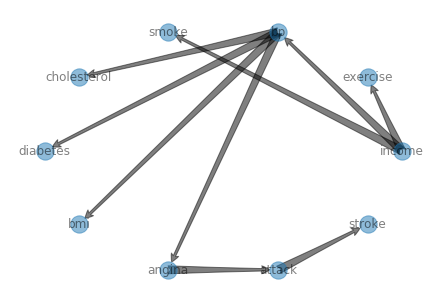

In [20]:
from pgmpy.estimators import TreeSearch
import networkx as nx
import matplotlib.pyplot as plt
est = TreeSearch(data,root_node="income")
model = est.estimate(estimator_type='chow-liu')
nx.draw_circular(model, with_labels=True, arrowsize=20, arrowstyle='fancy',alpha=0.5)
plt.savefig("new_model.jpg",format="PNG")

plt.show()

Construct bayes network based on new network structure

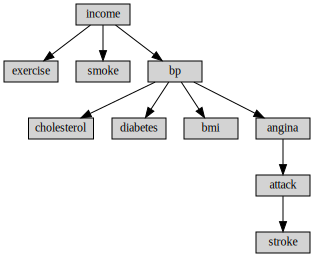

In [37]:
new_model = BayesianModel([("income","exercise"),("income","smoke"),("income","bp"),
                           ("bp","cholesterol"),("bp","diabetes"),("bp","bmi"),("bp","angina"),
                           ("angina","attack"),
                           ("attack","stroke")])

showBN(new_model)

Calculate the log likelihood on the training set based on the new network structure

In [22]:
dir_mle = BayesianEstimator(new_model,train)
train_ave = average_dirichlet_log_likelihood(dir_mle,train.columns)
print("the average log-likelihood on the training data",train_ave)

the average log-likelihood on the training data -0.021918556415906936


Calculate the log likelihood on the valid set based on the new network structure

In [23]:
dir_mle = BayesianEstimator(new_model,valid)
valid_ave = average_dirichlet_log_likelihood(dir_mle,valid.columns)
print("the average log-likelihood on the valid data",valid_ave)

the average log-likelihood on the valid data -0.024457353584377353


In [24]:
new_dir_mle = BayesianEstimator(new_model,train)
new_model_params,new_model_all_parameters = statics_parameters(dir_mle)
new_train_ave = average_dirichlet_log_likelihood(new_dir_mle,train.columns)

root_dir_mle = BayesianEstimator(root_model,train)
root_params,root_all_parameters = statics_parameters(root_dir_mle)
root_train_ave = average_dirichlet_log_likelihood(root_dir_mle,train.columns)

m= len(train)

new_model_bic = new_train_ave-(new_model_params/2)*math.log(m)/m
old_model_bic = root_train_ave-(root_params/2)*math.log(m)/m

print("Log likelihood after adding BIC penalty to the new network structure on the training data",new_model_bic)
print("Log likelihood after adding BIC penalty to the old network structure on the training data",old_model_bic)


Log likelihood after adding BIC penalty to the new network structure on the training data -0.023955240988366048
Log likelihood after adding BIC penalty to the old network structure on the training data -0.014826120977365586


By comparing the new model, it performs relatively better.



In [7]:
train.columns


Index(['income', 'smoke', 'cholesterol', 'bmi', 'exercise', 'attack', 'bp',
       'angina', 'stroke', 'diabetes'],
      dtype='object')

In [8]:
import pyGM as gm
variables = []
factors = []
IDtoName= {}
for index,column in enumerate(train.columns):
    print(train[column].unique())
    variable = gm.Var(index,len(train[column].unique()))
    IDtoName[column] = variable.label
    factor = gm.Factor([variable])
    # print(factor.vars)
    # factor.table = train[column].values
    factors.append(factor)
    variables.append(variable)

# factors = gm.Factor(tuple(variables))
    
model = gm.GraphModel(factors)

[5 1 4 7 6 2 3 0]
[1 0]
[1 0]
[3 2 1 0]
[1 0]
[1 0]
[0 2 1 3]
[1 0]
[1 0]
[2 0 1 3]


In [9]:
D = train.values.tolist()

In [10]:
phat = {}
for i in model.X: # estimate single-variable probabilities
    phat[i] = gm.Factor([i],1e-15)
    for xs in D: 
        phat[i][xs[i]] += 1.0
    phat[i] /= len(D)

for i in model.X: # estimate pairwise probabilities
    for j in model.X:
        if j<=i: continue
        phat[i,j] = gm.Factor([i,j],1e-15)
        for xs in D: 
            phat[i,j][xs[i],xs[j]] += 1.0
        phat[i,j] /= len(D)

In [20]:
print(phat)

{Var (0,8): Factor({0},[0x26c222adfa0]), Var (1,2): Factor({1},[0x26c223f55d0]), Var (2,2): Factor({2},[0x26c223f5610]), Var (3,4): Factor({3},[0x26c1aeeca20]), Var (4,2): Factor({4},[0x26c223f58d0]), Var (5,2): Factor({5},[0x26c223f5930]), Var (6,4): Factor({6},[0x26c1aeec900]), Var (7,2): Factor({7},[0x26c223f5970]), Var (8,2): Factor({8},[0x26c223f59f0]), Var (9,4): Factor({9},[0x26c1aeec8d0]), (Var (0,8), Var (1,2)): Factor({0,1},[0x26c1a1a1d50]), (Var (0,8), Var (2,2)): Factor({0,2},[0x26c1a1a2a40]), (Var (0,8), Var (3,4)): Factor({0,3},[0x26c192f4960]), (Var (0,8), Var (4,2)): Factor({0,4},[0x26c1a1a2d10]), (Var (0,8), Var (5,2)): Factor({0,5},[0x26c1a1a1ba0]), (Var (0,8), Var (6,4)): Factor({0,6},[0x26c192f4a70]), (Var (0,8), Var (7,2)): Factor({0,7},[0x26c1a1a1f90]), (Var (0,8), Var (8,2)): Factor({0,8},[0x26c1a1a3460]), (Var (0,8), Var (9,4)): Factor({0,9},[0x26c192f3b90]), (Var (1,2), Var (2,2)): Factor({1,2},[0x26c74594ad0]), (Var (1,2), Var (3,4)): Factor({1,3},[0x26c222ae5

In [16]:
#  compute the Chow-Liu weights
import numpy as np
wts = np.zeros((10,10))
for i in model.X: # estimate pairwise probabilities
    for j in model.X:
        if j<=i: continue # estimate (empirical) mutual informati on:
        wts[i,j] = (phat[i,j] * (phat[i,j]/phat[i]/phat[j]).log() ).sum()
np.set_printoptions(precision=4, suppress=True)
print(np.round(wts,4))

[[0.     0.0084 0.0052 0.0067 0.0194 0.0098 0.0198 0.0071 0.0095 0.0154]
 [0.     0.     0.004  0.0004 0.0031 0.0055 0.0035 0.0042 0.0016 0.0013]
 [0.     0.     0.     0.0097 0.003  0.0101 0.0428 0.0145 0.004  0.0196]
 [0.     0.     0.     0.     0.0091 0.0011 0.0281 0.0016 0.0004 0.0258]
 [0.     0.     0.     0.     0.     0.0029 0.0074 0.0024 0.0025 0.006 ]
 [0.     0.     0.     0.     0.     0.     0.0137 0.0569 0.0115 0.0096]
 [0.     0.     0.     0.     0.     0.     0.     0.0177 0.0091 0.0386]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0087 0.01  ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0046]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


In [17]:
pos = {'Income': (2,3), 'Exercise':(1,2), 'Smoke':(3,2), 'BMI':(0,1), 'BP':(2,1),'cholesterol':(3,1), 
       'diabetes':(0,0), 'Stroke':(1,0), 'Attack':(2,0), 'Angina':(3,0)}

In [38]:
IDtoName

{'income': 0,
 'smoke': 1,
 'cholesterol': 2,
 'bmi': 3,
 'exercise': 4,
 'attack': 5,
 'bp': 6,
 'angina': 7,
 'stroke': 8,
 'diabetes': 9}

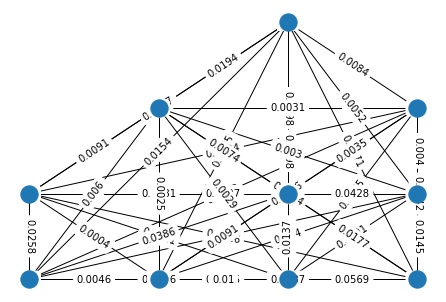

In [19]:
import networkx as nx
import numpy as np
newpos= {}
for k,v in pos.items():
    newpos[IDtoName[k.lower()]] = v
    
    
G=nx.Graph()
# I will manually position the nodes of the graph:
labels={}
for Xi in variables:
    G.add_node(Xi.label )
for i in range(10):
    for j in range(i,10):
        G.add_edge(i,j, weight=wts[i,j])
        labels[(i,j)] = np.round(wts[i,j],4)
# draw the graph with my manual positioning:
nx.draw(G,newpos)
nx.draw_networkx_edge_labels(G,newpos,edge_labels=labels);

The weight threshold is selected to be 0.01, and the two points connected by the edge with the weight greater than the threshold are retained.
So keep the following edges;

In [52]:
con_nodes = list(zip(*np.where(wts>=0.01)))

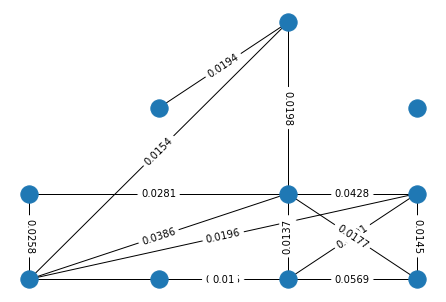

In [53]:
G=nx.Graph()
# I will manually position the nodes of the graph:
labels={}
for Xi in variables:
    G.add_node(Xi.label )
for i,j in con_nodes:
    G.add_edge(i,j, weight=wts[i,j])
    labels[(i,j)] = np.round(wts[i,j],4)
# draw the graph with my manual positioning:
nx.draw(G,newpos)
nx.draw_networkx_edge_labels(G,newpos,edge_labels=labels);

In [54]:

factors = [phat[i] for i in range(10)] + [phat[i,j]/phat[i]/phat[j] for i,j in con_nodes]
est_model = gm.GraphModel(factors)


In [55]:
factors = [phat[i] for i in range(10)] + [phat[i,j]/phat[i]/phat[j] \
                                          for i,j in [(0,3),(0,4),(0,1),(0,2),(0,6),
                                                      (1,6,),(1,2),
                                                      (2,8),(2,5),(2,7),
                                                      (3,9),(3,8),(3,5),(3,7),
                                                      (3,4),(4,6),(2,4),
                                                      (6,8),(5,6),(6,7)]]
old_model = gm.GraphModel(factors)

Calculate the log likelihood on the training set based on the new network structure

In [62]:
m = len(D)

print( "the new model ll on train data: "+str(np.mean([est_model.logValue(x) for x in D])) )

the new model ll on train data: -6.621723955713178


Calculate the log likelihood on the valid set based on the new network structure

In [63]:
valid_D= valid.values.tolist()
print( "the new model ll on valid data: "+str(np.mean([est_model.logValue(x) for x in valid_D])) )

the new model ll on valid data: -6.661952630939217


In [ ]:
id2name = {v:k for k,v in IDtoName.items()}
new_model_graph = []
for i,j in con_nodes:
    new_model_graph.append((id2name[i],id2name[j]))
new_model = BayesianModel(new_model_graph)

showBN(new_model,"new_model")

In [45]:
from pgmpy.estimators import MaximumLikelihoodEstimator
new_model_mle = MaximumLikelihoodEstimator(new_model,train)
all_estimate_parameters,all_parameters = statics_parameters(new_model_mle)
print("the total number of probabilities you need to estimate for this new network:",all_estimate_parameters)
print("the total number of probabilities in the full joint distribution",all_parameters)

the total number of probabilities you need to estimate for this network: 7303.0
the total number of probabilities in the full joint distribution 9960


In [64]:
print( "True model LL+BIC on train data: "+str(np.mean([old_model.logValue(x) for x in D])-(307/2)*np.log(m)/m ))
print( "Best tree LL+BIC on train data: "+str(np.mean([est_model.logValue(x) for x in D])-(7303/2)*np.log(m)/m))

True model LL+BIC on train data: -6.788766500794958
Best tree LL+BIC on train data: -6.800927659721237


By comparing the new model, it performs relatively better.
